In [26]:
import json
import os

import dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dotenv.load_dotenv(override=True)

DATA = os.getenv("DATA")
MTSD = os.getenv("MTSD")
if not DATA:
    raise Exception('Not able to find "DATA" environment variable')
if not MTSD:
    raise Exception('Not able to find "MTSD" environment variable')

In [109]:
classes_dir = os.path.join(DATA, 'classes')
anno_dir = os.path.join(MTSD, 'annotations')
print(classes_dir)
print(anno_dir)

C:\Users\saibo\Documents\bachelor_project\data\classes
C:\Users\saibo\Documents\bachelor_project\data\MTSD\annotations


In [110]:
anno_files = os.listdir(anno_dir)
len(anno_files)

41909

In [111]:
with open(os.path.join(classes_dir, "classes.json")) as f:
    classes = json.load(f)
len(classes)

402

In [112]:
with open(os.path.join(classes_dir, 'delete.txt')) as f:
    delete = f.readlines()
delete = [s.replace('\n', '') for s in delete]
delete = [s for s in delete if s != '']
len(delete)

182

In [113]:
new_anno_dir = os.path.join(os.path.dirname(anno_dir), 'anno_2')
os.makedirs(new_anno_dir, exist_ok=True)
print(new_anno_dir)

C:\Users\saibo\Documents\bachelor_project\data\MTSD\anno_2


In [8]:
n_pano = 0
n_in_delete = 0

for anno_file in anno_files:
    with open(os.path.join(anno_dir, anno_file)) as f:
        anno = json.load(f)
    
    if anno['ispano']:
        n_pano += 1
        continue
    
    anno_new = {
        'labels': [],
        'boxes': [],
        'areas': [],
        }
    keep_anno = True

    for obj in anno['objects']:
        if obj['label'] in delete:
            n_in_delete += 1
            keep_anno = False
            break

        anno_new['labels'].append(obj['label'])
        box = obj['bbox']
        anno_new['boxes'].append([box['xmin'], box['ymin'], box['xmax'], box['ymax']])
        anno_new['areas'].append((box['xmax'] - box['xmin']) * (box['ymax'] - box['ymin']))

    if keep_anno:
        filename = os.path.join(new_anno_dir, anno_file)
        with open(filename, "w+") as f:
            json.dump(anno_new, f, indent=6)

n_pano, n_in_delete

(941, 14697)

In [114]:
anno_files = os.listdir(new_anno_dir)
len(anno_files)

26271

In [11]:
n_no_signs = []

for anno_file in anno_files:
    try:
        with open(os.path.join(new_anno_dir, anno_file)) as f:
            anno = json.load(f)
        if len(anno['labels']) == 0:
            n_no_signs += [anno_file]
    except Exception as e:
        print(anno_file)

In [12]:
len(n_no_signs)

128

In [115]:
with open(os.path.join(classes_dir, 'keep.txt')) as f:
    keep = f.readlines()
keep = [s.replace('\n', '') for s in keep]
keep = [s for s in keep if s != '']
len(keep)

57

In [116]:
with open(os.path.join(classes_dir, 'map_mtsd2str.json')) as f:
    map_mtsd2str = json.load(f)
keep_str = list(set([map_mtsd2str[label] for label in keep]))
len(keep_str)

53

In [117]:
count = {}
areas = []

for anno_file in anno_files:
    with open(os.path.join(new_anno_dir, anno_file)) as f:
        anno = json.load(f)

    for label, area in zip(anno['labels'], anno['areas']):
        if label in keep:
            areas.append(area)
            label = map_mtsd2str[label]
            if label in count:
                count[label] += 1
            else:
                count[label] = 1
len(count)

53

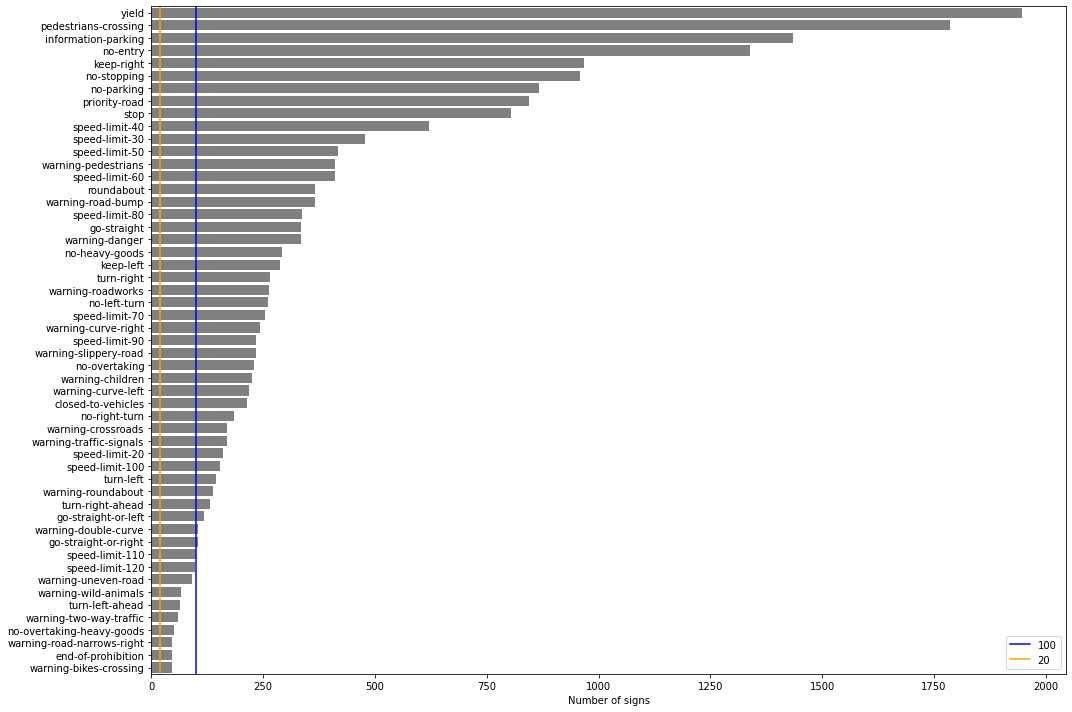

In [129]:
def plot_count(x, y):
    fig = plt.figure(figsize=(15,10))
    sns.barplot(x=x, y=y, color='gray')
    plt.axvline(100, 0, 1, color='blue', label='100')
    plt.axvline(20, 0, 1, color='orange', label='20')
    plt.xlabel('Number of signs')
    plt.tight_layout()
    plt.legend()
    plt.show()

y, x = zip(*sorted(count.items(), key=lambda x: -x[1]))

plot_count(x=list(x), y=list(y))

In [130]:
sorted(count.items(), key=lambda x: x[1])[:5]

[('warning-bikes-crossing', 45),
 ('warning-road-narrows-right', 46),
 ('end-of-prohibition', 46),
 ('no-overtaking-heavy-goods', 51),
 ('warning-two-way-traffic', 59)]

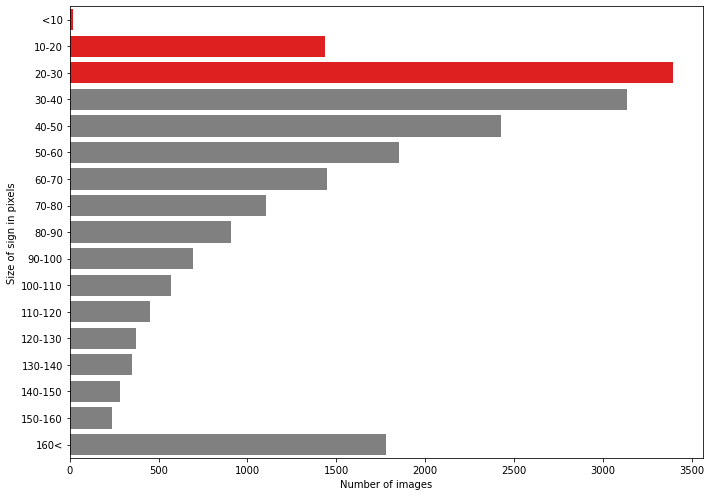

In [131]:
bins = list(range(10, 161, 10))

bin_labels = [str(i-10) + "-" + str(i) for i in bins] + ['160<']
bin_labels[0] = '<10'

bins = {((bin-10)**2, bin**2):0 for bin in bins}
bins[(160**2, 1e8)] = 0

for c in areas:
    for bin in bins:
        if c >= bin[0] and c < bin[1]:
            bins[bin] += 1

x = list(bins.values())
y = [str(key) for key in bins.keys()]
cmap = ['red'] * 3 + ['gray'] * (len(x) - 3)

fig = plt.figure(figsize=(10,7))
sns.barplot(y=y, x=x, palette=cmap)
plt.xlabel('Number of images')
plt.ylabel('Size of sign in pixels')
plt.yticks(np.arange(len(bin_labels)), bin_labels)
plt.tight_layout()
plt.show()

In [132]:
sum(list(bins.values())[:3]), sum(list(bins.values())[3:])

(4854, 15617)

In [133]:
count2 = {}
n_too_small = 0
threshold = 30**2

for anno_file in anno_files:
    with open(os.path.join(new_anno_dir, anno_file)) as f:
        anno = json.load(f)

    for label, area in zip(anno['labels'], anno['areas']):
        if label in keep:
            label = map_mtsd2str[label]
            if area < threshold:
                n_too_small += 1
            else:
                if label in count2:
                    count2[label] += 1
                else:
                    count2[label] = 1
len(count2), n_too_small

(53, 4854)

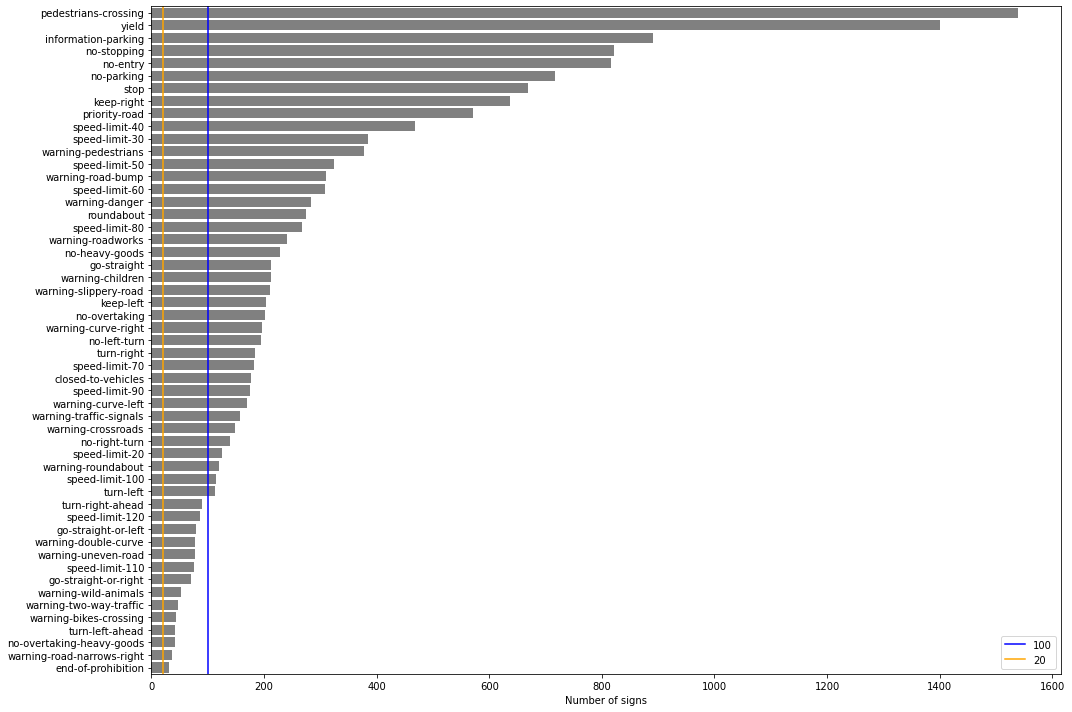

In [135]:
y, x = zip(*sorted(count2.items(), key=lambda x: -x[1]))
plot_count(x=list(x), y=list(y))

In [136]:
sorted(count2.items(), key=lambda x: x[1])[:5]

[('end-of-prohibition', 31),
 ('warning-road-narrows-right', 36),
 ('turn-left-ahead', 41),
 ('no-overtaking-heavy-goods', 41),
 ('warning-bikes-crossing', 43)]

In [141]:
new_anno_dir2 = os.path.join(os.path.dirname(anno_dir), 'anno_53')
os.makedirs(new_anno_dir2, exist_ok=True)
print(new_anno_dir2)

C:\Users\saibo\Documents\bachelor_project\data\MTSD\anno_53


In [138]:
with open(os.path.join(classes_dir, 'map_str2num.json')) as f:
    map_str2num = json.load(f)
len(map_str2num)

53

In [142]:
n_img_too_small = 0
n_imgs = 0
threshold = 30**2
num_labels = 53

for anno_file in anno_files:
    with open(os.path.join(new_anno_dir, anno_file)) as f:
        anno = json.load(f)
    
    anno_new = {
        'labels': [],
        'labels_str': [],
        'boxes': [],
        'areas': [],
        }
    keep_anno = False

    for label, box, area in zip(anno['labels'], anno['boxes'], anno['areas']):
        if label in keep:
            if area >= threshold:
                keep_anno = True
            anno_new['labels'].append(map_str2num[map_mtsd2str[label]])
            anno_new['labels_str'].append(map_mtsd2str[label])
        else:
            anno_new['labels'].append(num_labels + 1)
            anno_new['labels_str'].append('other-sign')

        anno_new['boxes'].append(box)
        anno_new['areas'].append(area)

    if keep_anno:
        n_imgs += 1
        filename = os.path.join(new_anno_dir2, anno_file)
        with open(filename, "w+") as f:
            json.dump(anno_new, f, indent=6)
    else:
        n_img_too_small

n_imgs, n_img_too_small

(8977, 0)

In [224]:
from sklearn.model_selection import train_test_split

In [225]:
anno_files = os.listdir(new_anno_dir2)
len(anno_files)

8977

In [247]:
threshold = 30**2
data = []

for anno_file in anno_files:
    with open(os.path.join(new_anno_dir2, anno_file)) as f:
        anno = json.load(f)

    for label, label_str, area in zip(anno['labels'], anno['labels_str'], anno['areas']):
        if label_str != 'other-sign' and area >= threshold:
            data.append([anno_file, int(label)])
    
len(data)

15617

In [253]:
ids = []
labels = []
sorted_labels = [x[0] for x in sorted(count2.items(), key=lambda x: x[1])]
for id, label in data:
    if id not in ids:
        for label2 in sorted_labels:
            if label == map_str2num[label2]:
                ids.append(id)
                labels.append(label)
                break
len(ids), len(labels)

(8977, 8977)

In [285]:
train_dir = os.path.join(os.path.dirname(anno_dir), 'anno_train')
os.makedirs(train_dir, exist_ok=True)
val_dir = os.path.join(os.path.dirname(anno_dir), 'anno_val')
os.makedirs(val_dir, exist_ok=True)
test_dir = os.path.join(os.path.dirname(anno_dir), 'anno_test')
os.makedirs(test_dir, exist_ok=True)

In [258]:
X_train, X_test, y_train, y_test = train_test_split(ids, labels, stratify=labels, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5)

In [261]:
print(len(X_train), len(X_val), len(X_test))
print(len(X_train)/len(anno_files), len(X_val)/len(anno_files), len(X_test)/len(anno_files))

5386 1795 1796
0.5999777208421522 0.19995544168430435 0.2000668374735435


In [286]:
train_files = set(X_train)
val_files = set(X_val)
test_files = set(X_test)

for anno_file in anno_files:
    with open(os.path.join(new_anno_dir2, anno_file)) as f:
        anno = json.load(f)
    
    if anno_file in train_files:
        with open(os.path.join(train_dir, anno_file), "w+") as f:
            json.dump(anno, f, indent=6)

    if anno_file in val_files:
        with open(os.path.join(val_dir, anno_file), "w+") as f:
            json.dump(anno, f, indent=6)   
    
    if anno_file in test_files:
        with open(os.path.join(test_dir, anno_file), "w+") as f:
            json.dump(anno, f, indent=6)

In [289]:
def count_labels(dir_path, files):
    count = {}

    for anno_file in files:
        with open(os.path.join(dir_path, anno_file)) as f:
            anno = json.load(f)

        for label, label_str, area in zip(anno['labels'], anno['labels_str'], anno['areas']):
            if label_str != 'other-sign' and area >= threshold:
                if label in count:
                    count[label] += 1
                else:
                    count[label] = 1

    return sorted(count.items(), key=lambda x: x[0])

count_train = count_labels(train_dir, train_files)
count_val = count_labels(val_dir, val_files)
count_test = count_labels(test_dir, test_files)

[(30, 19), (23, 20), (32, 23), (9, 25), (28, 25)]


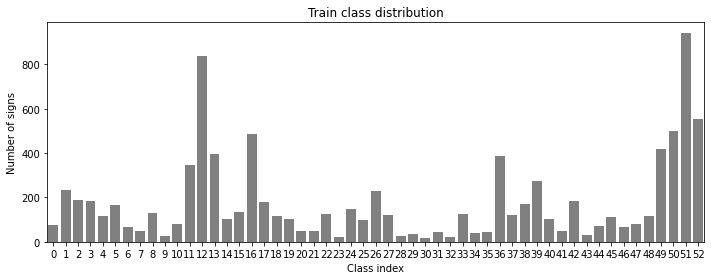

[(23, 6), (43, 6), (29, 8), (30, 8), (9, 9)]


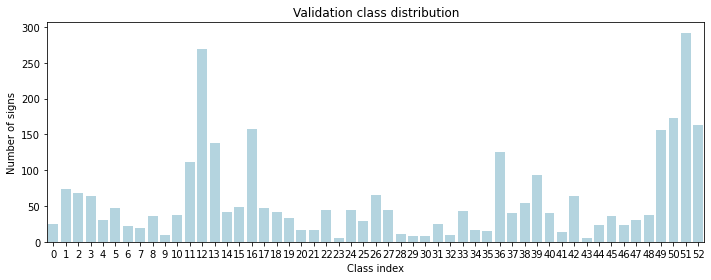

[(30, 4), (9, 7), (28, 7), (32, 9), (23, 10)]


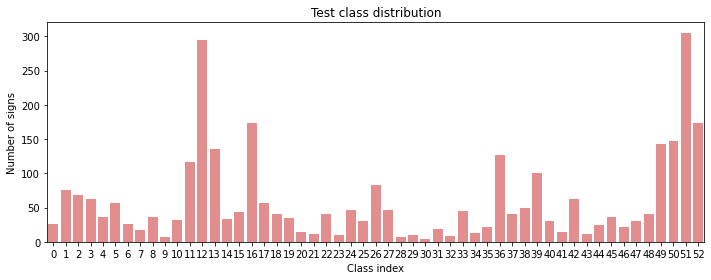

In [298]:
def plot_count2(count, title, color):
    x, y = zip(*count)
    fig = plt.figure(figsize=(10,4))
    sns.barplot(x=list(x), y=list(y), color=color)
    plt.ylabel('Number of signs')
    plt.xlabel('Class index')
    plt.title(title + ' class distribution')
    plt.tight_layout()
    plt.show()

counts = (count_train, count_val, count_test)
titles = ['Train', 'Validation', 'Test']
colors = ['gray', 'lightblue', 'lightcoral']

for i in range(3):
    print(sorted(counts[i], key=lambda x: x[1])[:5])
    plot_count2(counts[i], titles[i], colors[i])